In [100]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import pandas as pd
from pandas import Timestamp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import mplcursors
from pylab import rcParams
import seaborn as sns
import mplfinance as mpf
import datetime as dt
import time
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, KFold
import math

%matplotlib inline

N = 21
test_size = 0.20
valid_size = 0.20

In [35]:
AAPL_df = pd.read_csv('AAPL.csv', parse_dates = True, index_col = 0)
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE
0,2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
1,2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2,2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
3,2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
4,2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.076317


In [36]:
AAPL_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5121 entries, 0 to 5120
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       5121 non-null   object 
 1   HIGH       5121 non-null   float64
 2   LOW        5121 non-null   float64
 3   OPEN       5121 non-null   float64
 4   CLOSE      5121 non-null   float64
 5   VOLUME     5121 non-null   float64
 6   ADJ_CLOSE  5121 non-null   float64
dtypes: float64(6), object(1)
memory usage: 320.1+ KB


In [37]:
AAPL_df.loc[:, 'DATE'] = pd.to_datetime(AAPL_df['DATE'], format = '%Y-%m-%d')

In [38]:
AAPL_df.dtypes

DATE         datetime64[ns]
HIGH                float64
LOW                 float64
OPEN                float64
CLOSE               float64
VOLUME              float64
ADJ_CLOSE           float64
dtype: object

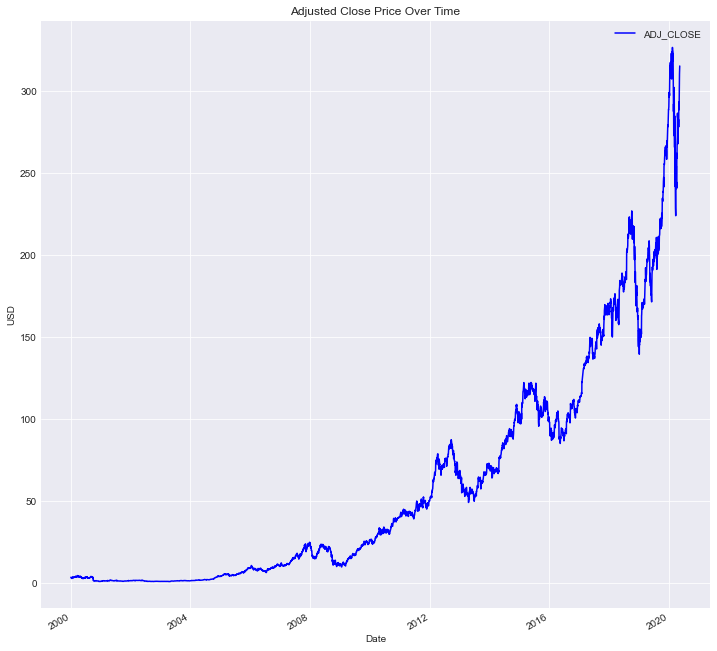

In [39]:
style.use('seaborn-darkgrid')

rcParams['figure.figsize'] = 12, 12

ax = AAPL_df.plot(x = 'DATE', y = 'ADJ_CLOSE', style = 'b-', grid = True)
ax.set_ylabel('USD')
ax.set_xlabel('Date')
ax.set_title('Adjusted Close Price Over Time');

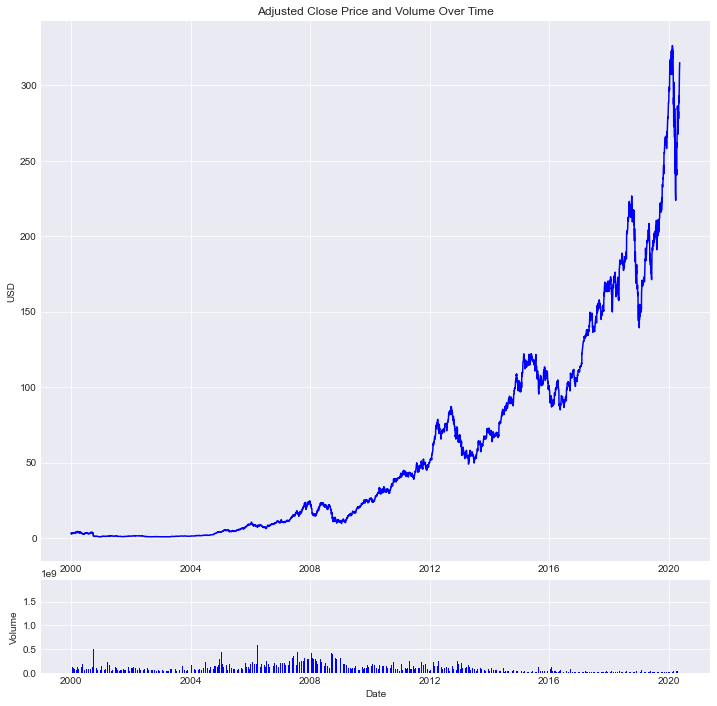

In [40]:
rcParams['figure.figsize'] = 12, 12

ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(AAPL_df['DATE'], AAPL_df['ADJ_CLOSE'], 'b-')
ax1.set_ylabel('USD')
ax1.set_title('Adjusted Close Price and Volume Over Time')
ax1.grid(True)

ax2.bar(AAPL_df['DATE'], AAPL_df['VOLUME'], color = 'blue')
ax2.grid(True)
ax2.set_ylabel('Volume')

plt.xlabel('Date')

plt.show()

In [41]:
AAPL_df['MONTH'] = AAPL_df['DATE'].dt.month
AAPL_df['RANGE_HL'] = AAPL_df['HIGH'] - AAPL_df['LOW']
AAPL_df['RANGE_OC'] = AAPL_df['OPEN'] - AAPL_df['CLOSE']
AAPL_df.head()

AAPL_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5121 entries, 0 to 5120
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       5121 non-null   datetime64[ns]
 1   HIGH       5121 non-null   float64       
 2   LOW        5121 non-null   float64       
 3   OPEN       5121 non-null   float64       
 4   CLOSE      5121 non-null   float64       
 5   VOLUME     5121 non-null   float64       
 6   ADJ_CLOSE  5121 non-null   float64       
 7   MONTH      5121 non-null   int64         
 8   RANGE_HL   5121 non-null   float64       
 9   RANGE_OC   5121 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 440.1 KB


In [42]:
AAPL_df['ORDER'] = [x for x in list(range(len(AAPL_df)))]

merging_col = ['ORDER']

lag_cols = ['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']
lag_cols

['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']

In [43]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm(shift_range):
    train_shift = AAPL_df[merging_col + lag_cols].copy()
    
    train_shift['ORDER'] = train_shift['ORDER'] + shift
    
    col_name = lambda x: '{}_LAG_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns = col_name)
    
    AAPL_df = pd.merge(AAPL_df, train_shift, on = merging_col, how = 'left')
    
del train_shift

AAPL_df = AAPL_df[N:]

AAPL_df.head()

<ipython-input-43-e775ed8bcc17>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm(shift_range):


,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,MONTH,RANGE_HL,RANGE_OC,...,OPEN_LAG_20,CLOSE_LAG_20,VOLUME_LAG_20,RANGE_HL_LAG_20,RANGE_OC_LAG_20,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21
21,2000-02-02,3.647321,3.464286,3.598214,3.529018,116048800.0,3.055062,2,0.183036,0.069196,...,3.866071,3.660714,128094400.0,0.337054,0.205357,3.745536,3.997768,133949200.0,0.386161,-0.252232
22,2000-02-03,3.723214,3.580357,3.582589,3.689732,118798400.0,3.194192,2,0.142857,-0.107143,...,3.705357,3.714286,194580400.0,0.270089,-0.008929,3.866071,3.660714,128094400.0,0.337054,0.205357
23,2000-02-04,3.928571,3.700893,3.712054,3.857143,106330000.0,3.339118,2,0.227679,-0.145089,...,3.790179,3.392857,191993200.0,0.428571,0.397321,3.705357,3.714286,194580400.0,0.270089,-0.008929
24,2000-02-07,4.080357,3.783482,3.857143,4.073661,110266800.0,3.526558,2,0.296875,-0.216518,...,3.446429,3.553571,115183600.0,0.196429,-0.107143,3.790179,3.392857,191993200.0,0.428571,0.397321
25,2000-02-08,4.147321,3.973214,4.071429,4.102679,102160800.0,3.551679,2,0.174107,-0.031250,...,3.642857,3.491071,126266000.0,0.267857,0.151786,3.446429,3.553571,115183600.0,0.196429,-0.107143


In [44]:
num_test = int(test_size * len(AAPL_df))
num_train = len(AAPL_df) - num_test
print('num_train:', str(num_train))
print('num_test:', str(num_test))
print('')

train = AAPL_df[:num_train]
test = AAPL_df[num_train:]
print('train.shape:', str(train.shape))
print('test.shape:', str(test.shape))

num_train: 4080
num_test: 1020

train.shape: (4080, 116)
test.shape: (1020, 116)


In [45]:
features_list = []

for i in range(1, N+1):
    features_list.append('OPEN_LAG_'+str(i))
    features_list.append('CLOSE_LAG_'+str(i))
    features_list.append('VOLUME_LAG_'+str(i))
    features_list.append('RANGE_HL_LAG_'+str(i))
    features_list.append('RANGE_OC_LAG_'+str(i))
    
target = 'ADJ_CLOSE'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

print('X_train.shape:', str(X_train.shape))
print('y_train.shape:', str(y_train.shape))
print('X_test.shape:', str(X_test.shape))
print('y_test.shape:', str(y_test.shape))

X_train.shape: (4080, 105)
y_train.shape: (4080,)
X_test.shape: (1020, 105)
y_test.shape: (1020,)


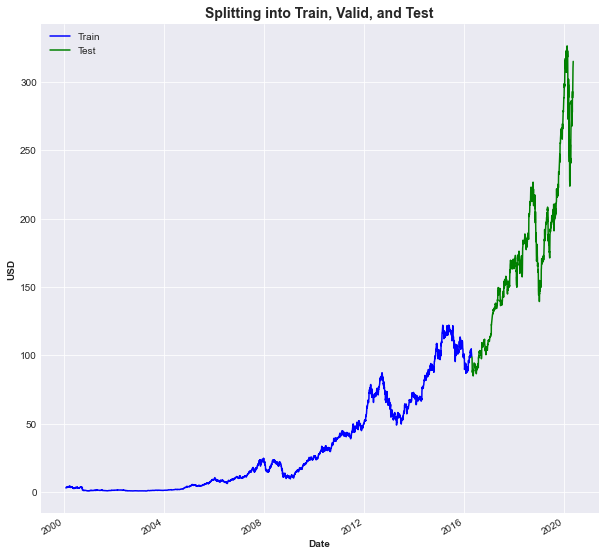

In [46]:
rcParams['figure.figsize'] = 10, 10

ax = train.plot(x='DATE', y='ADJ_CLOSE', style='b-', grid=True)
ax = test.plot(x='DATE', y='ADJ_CLOSE', style='g-', grid=True, ax=ax)
ax.legend(['Train', 'Test'])
ax.set_xlabel("Date", fontweight = 'bold')
ax.set_ylabel("USD", fontweight = 'bold')
ax.set_title("Splitting into Train, Valid, and Test", fontsize = 14, fontweight = 'bold');

In [47]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [48]:
model = LinearRegression()

model.fit(X_train_scaled, y_train_scaled)

predict_train_scaled = model.predict(X_train_scaled)
predict_train = scaler.inverse_transform(predict_train_scaled.reshape(-1, 1))

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 1.7661160084830627
MAE on Train Set = 0.8616390174764462


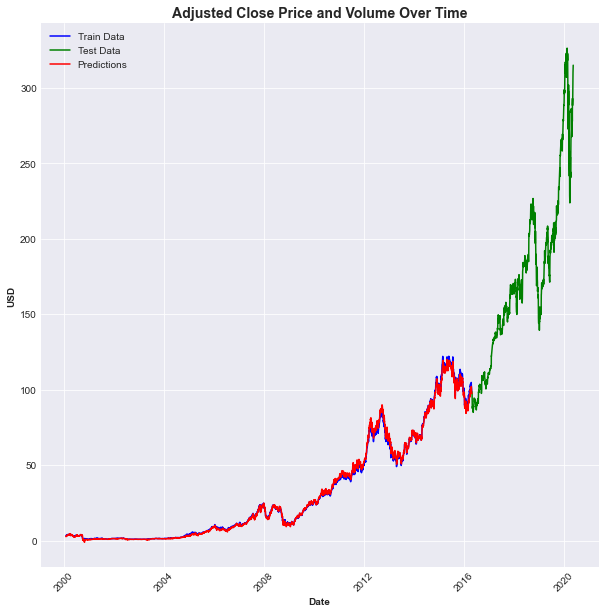

In [49]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(train['DATE'], predict_train, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [50]:
predict_test_scaled = model.predict(X_test_scaled)
predict_test = scaler.inverse_transform(predict_test_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_test, predict_test))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_test, predict_test)))
print('MAE on Test Set =', mean_absolute_error(y_test, predict_test))

MSE on Test Set = 205.85084735235858
RMSE on Test Set = 14.347503174850967
MAE on Test Set = 12.27520082741948


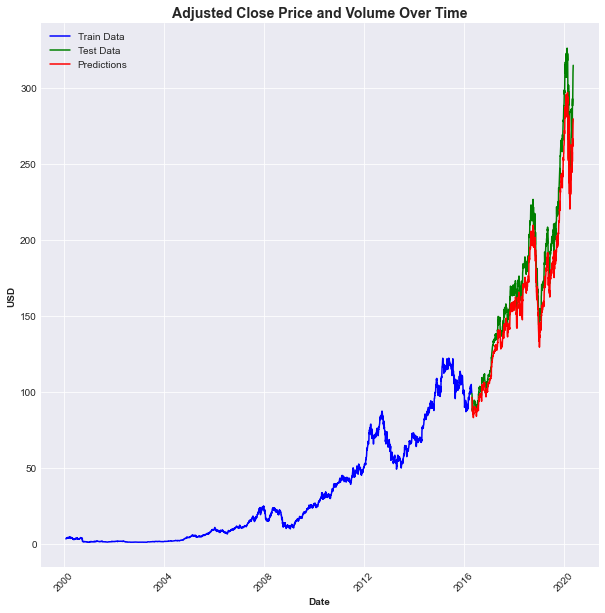

In [51]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(test['DATE'], predict_test, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [52]:
model = DecisionTreeRegressor()

model.fit(X_train_scaled, y_train_scaled)

predict_train_scaled = model.predict(X_train_scaled)
predict_train = scaler.inverse_transform(predict_train_scaled.reshape(-1, 1))

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 2.3910916679534664e-05
MAE on Train Set = 0.00273568658076913


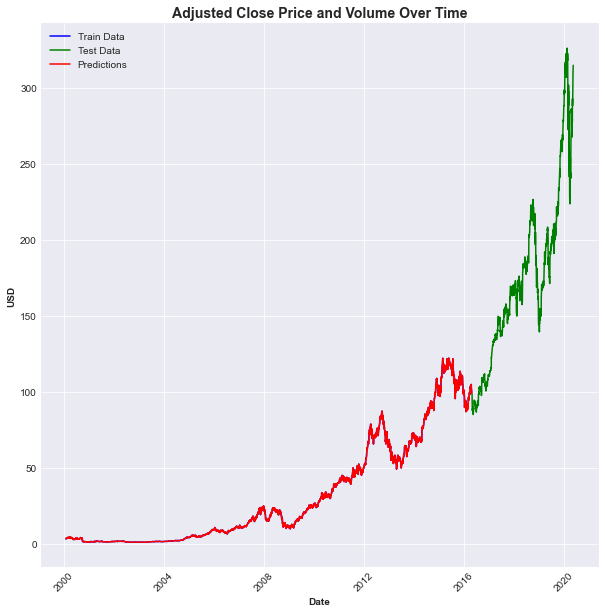

In [53]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(train['DATE'], predict_train, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [54]:
predict_test_scaled = model.predict(X_test_scaled)
predict_test = scaler.inverse_transform(predict_test_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_test, predict_test))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_test, predict_test)))
print('MAE on Test Set =', mean_absolute_error(y_test, predict_test))

MSE on Test Set = 6013.0279649107015
RMSE on Test Set = 77.54371647600276
MAE on Test Set = 58.55019697675518


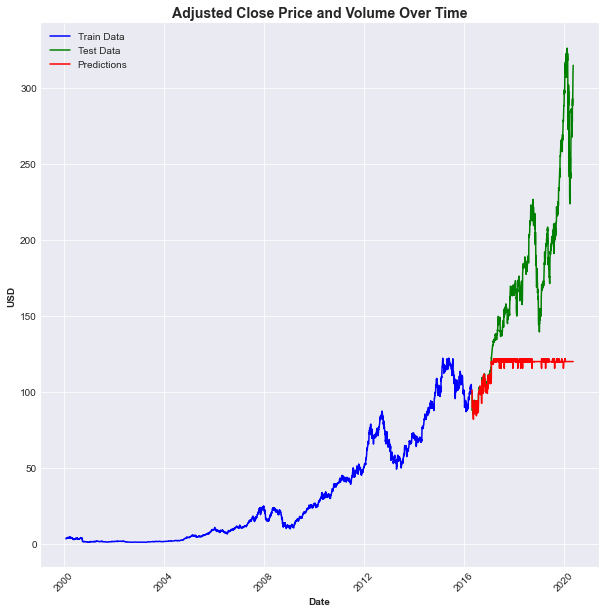

In [55]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(test['DATE'], predict_test, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [57]:
valid_len = int(valid_size * len(AAPL_df))
test_len = int(test_size * len(AAPL_df))
train_len = len(AAPL_df) - (valid_len + test_len)
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))
print('Valid Set Len: ' + str(valid_len))

train = AAPL_df[:train_len]
valid = AAPL_df[train_len:(train_len + valid_len)]
test = AAPL_df[(train_len + valid_len):]
print('Train Set Shape: ' + str(train.shape))
print('Valid Set Shape: ' + str(valid.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 3060
Test Set Len: 1020
Valid Set Len: 1020
Train Set Shape: (3060, 116)
Valid Set Shape: (1020, 116)
Test Set Shape: (1020, 116)


In [58]:
features_list = []

for i in range(1, N+1):
    features_list.append('OPEN_LAG_'+str(i))
    features_list.append('CLOSE_LAG_'+str(i))
    features_list.append('VOLUME_LAG_'+str(i))
    features_list.append('RANGE_HL_LAG_'+str(i))
    features_list.append('RANGE_OC_LAG_'+str(i))
    
target = 'ADJ_CLOSE'

X_train = train[features_list]
y_train = train[target]
X_valid = valid[features_list]
y_valid = valid[target]
X_test = test[features_list]
y_test = test[target]

print('X_train.shape:', str(X_train.shape))
print('y_train.shape:', str(y_train.shape))
print('X_valid.shape:', str(X_train.shape))
print('y_valid.shape:', str(y_train.shape))
print('X_test.shape:', str(X_test.shape))
print('y_test.shape:', str(y_test.shape))

X_train.shape: (3060, 105)
y_train.shape: (3060,)
X_valid.shape: (3060, 105)
y_valid.shape: (3060,)
X_test.shape: (1020, 105)
y_test.shape: (1020,)


In [59]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [64]:
RanForModel = RandomForestRegressor()
RanForModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RanForModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)

print('MSE on Test Set =', mean_squared_error(y_train, train_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_train, train_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_train, train_predictions))

<ipython-input-64-2a22a70b171a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RanForModel.fit(X_train_scaled, y_train_scaled)


MSE on Test Set = 0.02347593101183742
RMSE on Test Set = 0.1532185726726281
MAE on Test Set = 0.08626953194239834


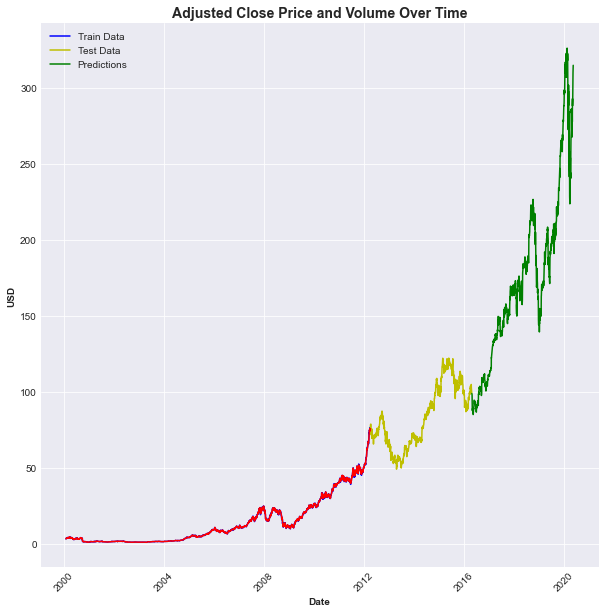

In [67]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(train['DATE'], train_predictions, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [69]:
valid_predictions_scaled = model.predict(X_valid_scaled)
valid_predictions = scaler.inverse_transform(valid_predictions_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_valid, valid_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_valid, valid_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_valid, valid_predictions))

MSE on Test Set = 1342.879090091172
RMSE on Test Set = 36.645314708584124
MAE on Test Set = 30.508016932277172


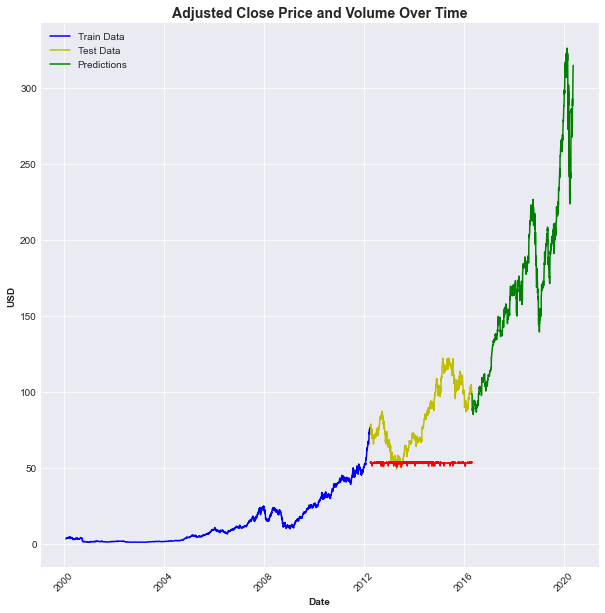

In [70]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(valid['DATE'], valid_predictions, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [105]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [106]:
RanForModel = RandomForestRegressor()
RanForModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RanForModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(np.array(train_predictions_scaled).reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_train, train_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_train, train_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_train, train_predictions))

<ipython-input-106-2cc40d4e327a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RanForModel.fit(X_train_scaled, y_train_scaled)


MSE on Test Set = 0.022986753740989754
RMSE on Test Set = 0.15161383096864794
MAE on Test Set = 0.08792328007288158


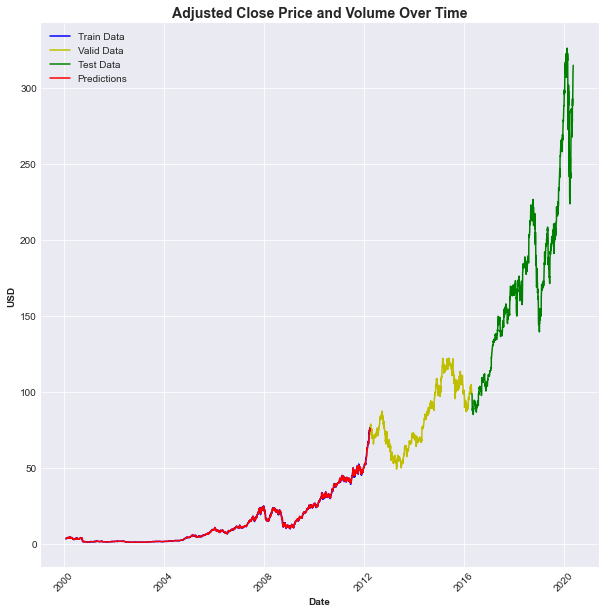

In [107]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(train['DATE'], train_predictions, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [108]:
valid_predictions_scaled = RanForModel.predict(X_valid_scaled)
valid_predictions = scaler.inverse_transform(valid_predictions_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_valid, valid_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_valid, valid_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_valid, valid_predictions))

MSE on Test Set = 2207.7737391735363
RMSE on Test Set = 46.98695286112451
MAE on Test Set = 46.89574243819089


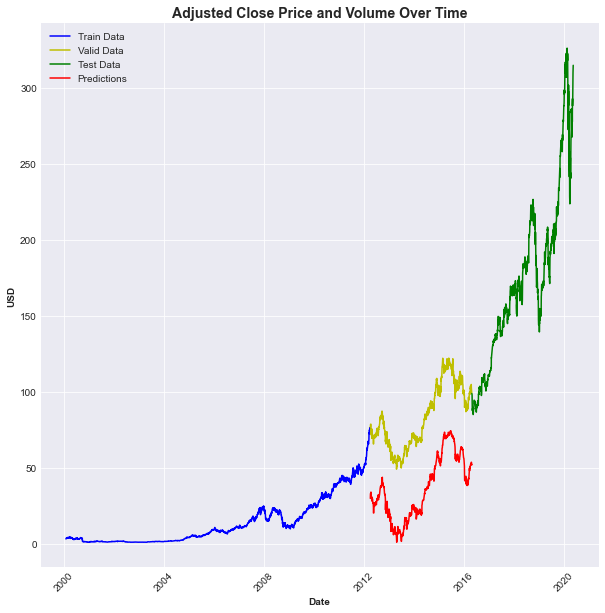

In [109]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(valid['DATE'], valid_predictions, 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [101]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [len(features_list)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

kfold = KFold(n_splits = 10)

RF_NewModel = GridSearchCV(estimator = RanForModel, param_grid = param_grid, 
                          cv = kfold, n_jobs = -1, verbose = 2, return_train_score=True)

RF_NewModel.fit(X_train_scaled, y_train_scaled);

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 74.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 121.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 182.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 259.8min finished
c:\python38\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [102]:
RF_NewModel.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 105,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [103]:
test_predictions_scaled = RF_NewModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_test, test_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_test, test_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_test, test_predictions))

MSE on Test Set = 13629.943331002754
RMSE on Test Set = 116.74734828253169
MAE on Test Set = 103.17771864349831


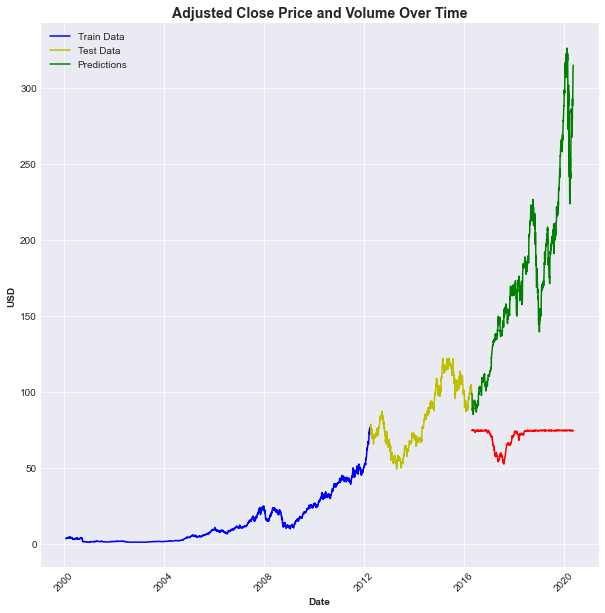

In [104]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(test['DATE'], test_predictions, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [84]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))

In [85]:
RanForModel = RandomForestRegressor()
RanForModel.fit(X_train_scaled, y_train_scaled)

train_predictions_scaled = RanForModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(np.array(train_predictions_scaled).reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_train, train_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_train, train_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_train, train_predictions))

<ipython-input-85-2cc40d4e327a>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RanForModel.fit(X_train_scaled, y_train_scaled)


MSE on Test Set = 0.022456359626049496
RMSE on Test Set = 0.1498544614819642
MAE on Test Set = 0.0847439088073867


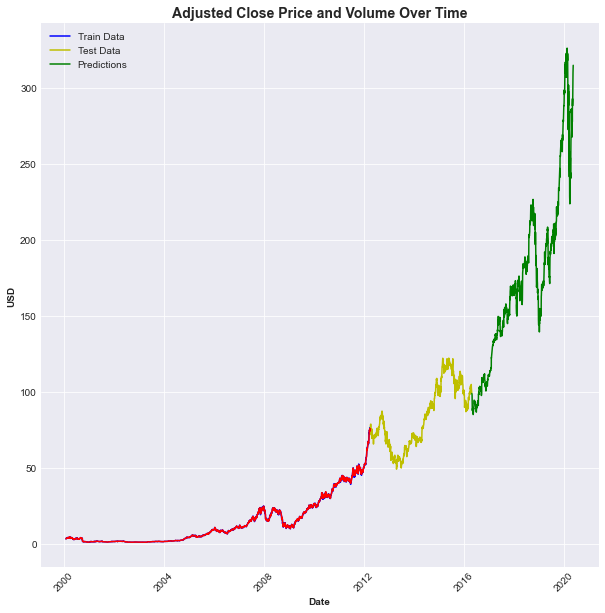

In [86]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(train['DATE'], train_predictions, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [87]:
valid_predictions_scaled = model.predict(X_valid_scaled)
valid_predictions = scaler.inverse_transform(valid_predictions_scaled.reshape(-1, 1))

print('MSE on Test Set =', mean_squared_error(y_valid, valid_predictions))
print('RMSE on Test Set =', math.sqrt(mean_squared_error(y_valid, valid_predictions)))
print('MAE on Test Set =', mean_absolute_error(y_valid, valid_predictions))

MSE on Test Set = 1057.1960282767134
RMSE on Test Set = 32.51455102376032
MAE on Test Set = 25.948840021451204


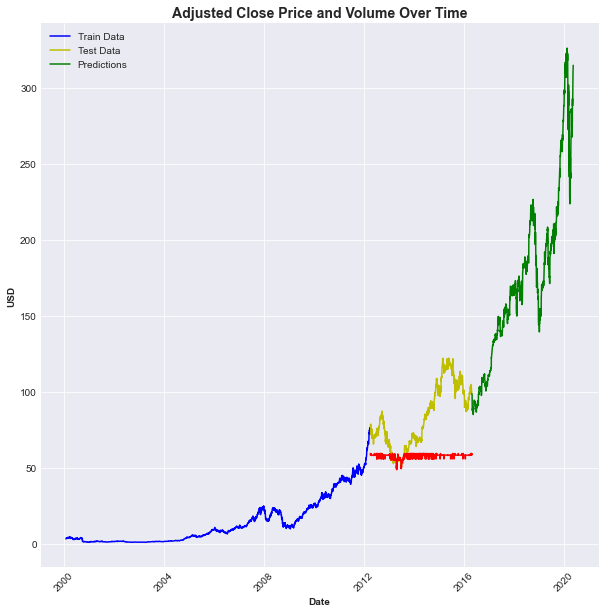

In [88]:
rcParams['figure.figsize'] = 10, 10

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(valid['DATE'], valid_predictions, 'r-')
plt.legend(['Train Data', 'Test Data', 'Predictions'], loc = 'upper left')
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()